This notebook contains:

*   Some initial analysis of the BRO 17lands draft dataset
*   Code to vectorize the draft data to an N-hot encoding
*   Some code to evaluate the trained model, including getting arena IDs and images from scryfall.

See https://github.com/iangonzalez/draft_bot/ for context.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import json
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#@title Set directory
#@markdown Input the base directory you are using for the project. Without this file path cells will fail.
_PROJECT_BASE_DIR = 'projects/draft_bot' #@param {type:"string"}

# Examining the dataset

Data downloaded from https://www.17lands.com/public_datasets. Change file path to your local path as needed (depending on where this notebook is running).

In [3]:
%pwd 

'/home/gonzalezi'

In [4]:
data_path = _PROJECT_BASE_DIR + "/data/BRO/raw/draft_data_public.BRO.PremierDraft.csv"

In [5]:
# How big is it? (too big to load into my poor 16GB RAM laptop?)
subprocess.run(["wc", "-l", data_path], capture_output=True)

# 4017250 total rows in the .csv

CompletedProcess(args=['wc', '-l', 'projects/draft_bot/data/BRO/raw/draft_data_public.BRO.PremierDraft.csv'], returncode=0, stdout=b'4017250 projects/draft_bot/data/BRO/raw/draft_data_public.BRO.PremierDraft.csv\n', stderr=b'')

In [6]:
# What data is in there? Let's read a tiny amount of the data just to look at
# the column names.
tiny_df =  pd.read_csv(data_path, nrows=1)
# print(sorted(tiny_df.columns))

In [7]:
# Most of them are prefixed with "pool_" or "pack_", which are encoding the
# user's pool and the pack

# Split pool cols, pack cards, and non-pool features

pool_cols = sorted([col for col in tiny_df.columns if "pool_" in col])
pack_cols = sorted([col for col in tiny_df.columns if "pack_card" in col])
non_card_cols = sorted([col for col in tiny_df.columns if "pool_" not in col and "pack_" not in col] + ["pack_number"])

In [8]:
# Shrink the memory footprint by squeezing counts into int8 (int64 is overkill)
# Can still only read 1M rows at a time for now.
df =  pd.read_csv(data_path, nrows=50000, dtype={ s: np.int8 for s in pool_cols + pack_cols }) 

In [9]:
df

,expansion,event_type,draft_id,draft_time,rank,event_match_wins,event_match_losses,pack_number,pick_number,pick,...,pool_Wurmcoil Engine,pool_Yotian Dissident,pool_Yotian Frontliner,pool_Yotian Medic,pool_Yotian Tactician,pool_Zephyr Sentinel,pack_card_Mishra's Bauble,pool_Mishra's Bauble,user_n_games_bucket,user_game_win_rate_bucket
0,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,0,Mechanized Warfare,...,0,0,0,0,0,0,0,0,10,0.52
1,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,1,Mishra's Research Desk,...,0,0,0,0,0,0,0,0,10,0.52
2,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,2,Sculpting Steel,...,0,0,0,0,0,0,0,0,10,0.52
3,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,3,Powerstone Engineer,...,0,0,0,0,0,0,0,0,10,0.52
4,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,4,Foundry Inspector,...,0,0,0,0,0,0,0,0,10,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,BRO,PremierDraft,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,NaN,2,3,1,12,Dredging Claw,...,0,0,0,0,0,1,0,0,10,0.54
49996,BRO,PremierDraft,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,NaN,2,3,1,13,Union of the Third Path,...,0,0,0,0,0,1,0,0,10,0.54
49997,BRO,PremierDraft,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,NaN,2,3,1,14,Tawnos's Tinkering,...,0,0,0,0,0,1,0,0,10,0.54
49998,BRO,PremierDraft,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,NaN,2,3,2,0,Powerstone Engineer,...,0,0,0,0,0,1,0,0,10,0.54


In [10]:
df.memory_usage().sum()

39100128

## Understanding non-card columns

Most are self-explanatory, lets dig into some of the ones that aren't.

TL;DR of findings:
- `pick_maindeck_rate`: How often the player included this card in their maindeck in the course of the draft
- `pick_sideboard_in_rate`: How often the player included the card out of their sideboard in a match. Meaningless in BO1
- `user_n_games_bucket`: Number of games the player has played (presumably draft games? not sure if restricted by format). Buckets seem to be 10, 50, 100, 500, 1000 (and beyond?).
- `user_game_win_rate_bucket`: This is the win rate for the player -- again, not entirely clear if it's retricted to draft, restricted to this format, etc. The buckets are pretty fine grained here, seem to be equivalent to rounding to 2 decimals.

In [11]:
non_card_cols

['draft_id',
 'draft_time',
 'event_match_losses',
 'event_match_wins',
 'event_type',
 'expansion',
 'pack_number',
 'pick',
 'pick_maindeck_rate',
 'pick_number',
 'pick_sideboard_in_rate',
 'rank',
 'user_game_win_rate_bucket',
 'user_n_games_bucket']

In [12]:
df[non_card_cols]

,draft_id,draft_time,event_match_losses,event_match_wins,event_type,expansion,pack_number,pick,pick_maindeck_rate,pick_number,pick_sideboard_in_rate,rank,user_game_win_rate_bucket,user_n_games_bucket
0,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,3,0,PremierDraft,BRO,0,Mechanized Warfare,0.0,0,0.0,silver,0.52,10
1,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,3,0,PremierDraft,BRO,0,Mishra's Research Desk,1.0,1,0.0,silver,0.52,10
2,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,3,0,PremierDraft,BRO,0,Sculpting Steel,1.0,2,0.0,silver,0.52,10
3,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,3,0,PremierDraft,BRO,0,Powerstone Engineer,1.0,3,0.0,silver,0.52,10
4,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,3,0,PremierDraft,BRO,0,Foundry Inspector,1.0,4,0.0,silver,0.52,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,3,2,PremierDraft,BRO,1,Dredging Claw,0.0,12,0.0,NaN,0.54,10
49996,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,3,2,PremierDraft,BRO,1,Union of the Third Path,0.0,13,0.0,NaN,0.54,10
49997,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,3,2,PremierDraft,BRO,1,Tawnos's Tinkering,0.0,14,0.0,NaN,0.54,10
49998,495f35c76745453d8cfa28dc7716145a,2022-11-15 23:58:29,3,2,PremierDraft,BRO,2,Powerstone Engineer,1.0,0,0.0,NaN,0.54,10


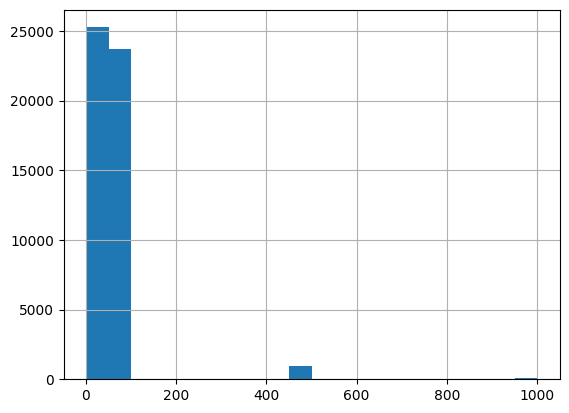

In [13]:
# user_n_games_bucket appears to be the number of games the user has played,
# bucketed (10, 50, 100, 500 .. not sure what all the buckets are)
hist = df["user_n_games_bucket"].hist(bins=20)

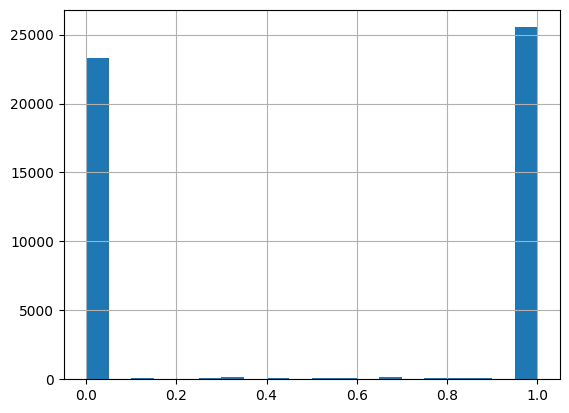

In [14]:
hist = df["pick_maindeck_rate"].hist(bins=20)

In [15]:
# What are the non 1, nonzero values?
pmr = df["pick_maindeck_rate"]
pmr[(pmr != 1.0) & (pmr != 0.0)]

38       0.6665
40       0.6665
225      0.2856
227      0.2856
228      0.7144
          ...  
49604    0.8750
49605    0.8750
49744    0.7500
49887    0.1666
49899    0.8335
Name: pick_maindeck_rate, Length: 1185, dtype: float64

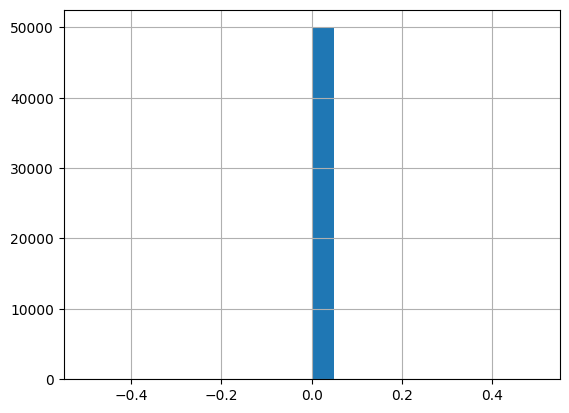

In [16]:
hist = df["pick_sideboard_in_rate"].hist(bins=20)

In [17]:
# What are the non 1, nonzero values?
psir = df["pick_sideboard_in_rate"]
psir[(psir != 1.0) & (psir != 0.0)]

Series([], Name: pick_sideboard_in_rate, dtype: float64)

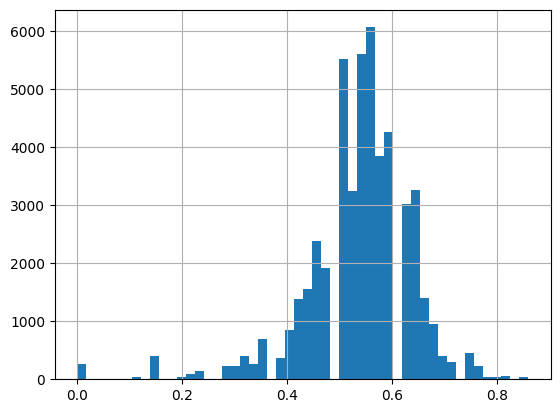

In [18]:
hist = df["user_game_win_rate_bucket"].hist(bins=50)

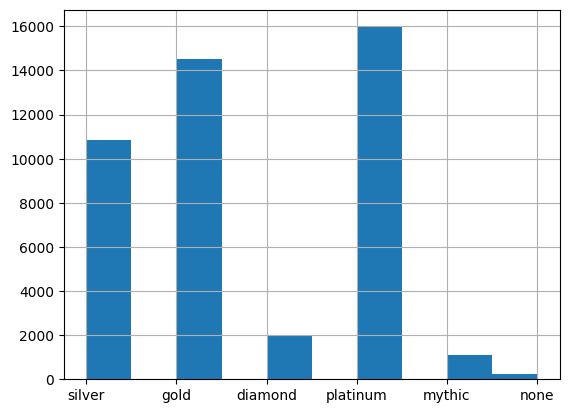

In [19]:
hist = df["rank"].hist()

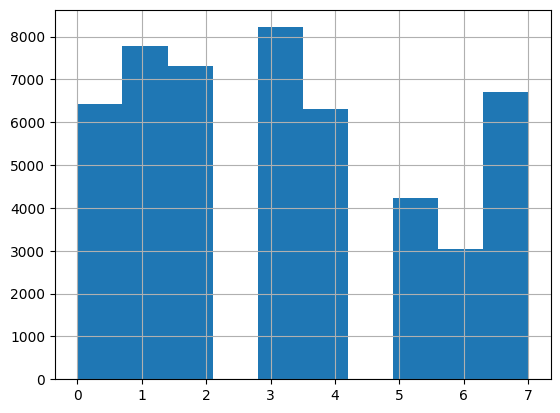

In [20]:
hist = df.event_match_wins.hist(bins=10)

## Are we missing P1P1?

17lands claims that some sets are missing P1P1 due to arena not exporting the right logs.

Doesn't seem to be a problem here -- these look like normal first picks

In [21]:
df[(df.pick_number == 0) & (df.pack_number == 0)]

,expansion,event_type,draft_id,draft_time,rank,event_match_wins,event_match_losses,pack_number,pick_number,pick,...,pool_Wurmcoil Engine,pool_Yotian Dissident,pool_Yotian Frontliner,pool_Yotian Medic,pool_Yotian Tactician,pool_Zephyr Sentinel,pack_card_Mishra's Bauble,pool_Mishra's Bauble,user_n_games_bucket,user_game_win_rate_bucket
0,BRO,PremierDraft,0fb9990af1074fd6a4e237b9953ab81a,2022-11-15 16:47:03,silver,0,3,0,0,Mechanized Warfare,...,0,0,0,0,0,0,0,0,10,0.52
45,BRO,PremierDraft,1464fe005e05480cb3b371d4995b765e,2022-11-15 17:35:13,silver,7,2,0,0,Titania's Command,...,0,0,0,0,0,0,0,0,10,0.52
90,BRO,PremierDraft,0df1c8352a3c4e4a8e6d19716eea9de0,2022-11-15 23:02:43,NaN,0,0,0,0,Titania's Command,...,0,0,0,0,0,0,0,0,10,0.52
135,BRO,PremierDraft,4b256ee3d0c14e3e906d1f55a87b4d98,2022-11-15 20:36:29,gold,3,3,0,0,"Mishra, Claimed by Gix",...,0,0,0,0,0,0,0,0,10,0.66
180,BRO,PremierDraft,facc93cb586c4b05b91dc049e449cc25,2022-11-15 21:19:28,silver,6,3,0,0,Corrupt,...,0,0,0,0,0,0,0,0,100,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49788,BRO,PremierDraft,585e7cc1d3944670ac22d67e71404a4e,2022-11-15 20:54:25,gold,1,3,0,0,Tocasia's Welcome,...,0,0,0,0,0,0,0,0,10,0.36
49833,BRO,PremierDraft,50046a38bad84399b6c3a5f6aa2fd447,2022-11-15 22:58:40,gold,2,3,0,0,Key to the City,...,0,0,0,0,0,0,0,0,10,0.36
49878,BRO,PremierDraft,44f78d3329e94c54bda1f6e8cf79c4c5,2022-11-15 19:53:45,silver,3,3,0,0,"Ashnod, Flesh Mechanist",...,0,0,0,0,0,0,0,0,100,0.60
49923,BRO,PremierDraft,0ed0ae9f6a094e14b5a8714948176b6c,2022-11-15 19:17:08,silver,7,2,0,0,Sundering Titan,...,0,0,0,0,0,0,0,0,100,0.58


## Does the pool already contain the picked card?

Nope. Good sanity check

In [22]:
pick_name0 = df.loc[1]["pick"] 
df.loc[1]["pool_" + pick_name0]

0

# Converting to vector representations

For BRO, there are 335 uniquely named cards you can open in a draft booster.
 This is 272 main set cards + 63 retro artifacts.
 Note that there are actually 287 main set cards, but 20 are basic lands, which
 are not differentiated in this data set (5 instead of 15).

 The vectorized representation of a set of cards will therefore be a length 335
 vector, with each entry representing the number of that card in the set.

 To standardize this, the vector representation maps to the alphabetized list of
 all 335 card names.

In [23]:
_SET_SIZE_DIM = len(pack_cols)

In [24]:
# pack_cols was already sorted above, double check
pack_cols = sorted(pack_cols)

In [25]:
prefix = "pack_card_"
sorted_card_names = [s[len(prefix):] if s.startswith(prefix) else s for s in pack_cols]

In [26]:
# Write card list to a file as json.
card_output_dir = _PROJECT_BASE_DIR + '/data/BRO/per_card_data/BRO_canonical_card_list.json'
with open(card_output_dir, 'w') as f:
  json.dump(sorted_card_names, f)

## Vectorizing picks

Time to vectorize the "pick" column! This is pretty easy, we just fill in a (num data rows) x (num cards) matrix with a single 1 marking the card in each row.

In [27]:
card_index_map = { s:i for i,s in enumerate(sorted_card_names) }
card_vec = np.zeros(_SET_SIZE_DIM, dtype=np.int8)
def card_names_to_vector(names, card_vec):
  """
  INPUT:
  - Iterable of card names. Invalid names will cause a crash.
  - Array of size 335 (card name list length). Expects that the array is filled
    with ints (ie created via np.zeros())
  """
  for name in names:
    assert name in card_index_map.keys()
    card_vec[card_index_map[name]] += 1

In [28]:
%time card_names_to_vector(["Mishra's Bauble"], card_vec)

CPU times: user 31 µs, sys: 8 µs, total: 39 µs
Wall time: 43.6 µs


In [29]:
# Vectorize the card for each pick
pick_matrix = np.zeros((df.shape[0], _SET_SIZE_DIM), dtype=np.int8)
for i, pick in enumerate(df["pick"]):
  card_names_to_vector([pick], pick_matrix[i])

In [30]:
# Quick and dirty verification that this worked (there should be one 1 for each
# row in the matrix)
pick_matrix.sum()

50000

## Vectorizing pack + pool

Next we need the state of the pack and the draft pool to be vectorized for each draft pick. This will end up being a matrix of size (num data rows) x (num_cards * 2), where the convention is to put the pack cards first (arbitrarily chosen).

This is actually super simple, the 17lands data is already almost in this format. We just need to rearrange the columns to match our canonicalized ordering. (My initial super slow attempt is kept below for posterity)

### Deprecated (slow) pack / pool vectorization

In [31]:
# A rather resource-intensive way of turning a row into the vectorized pack+pool
# format.
set_size_dim = len(sorted_card_names)
pack_pool_vec = np.zeros(set_size_dim * 2)
def convert_row_to_vectorized(row):
  pack_only_row = row[pack_cols]
  pack_prefix = "pack_card_"
  for col in pack_cols:
    # remove prefix
    card_name = col[len(pack_prefix):]
    pack_pool_vec[card_index_map[card_name]] += pack_only_row[col]

  pool_only_row = row[pool_cols]
  pool_prefix = "pool_"
  for col in pool_cols:
    # remove prefix
    card_name = col[len(pool_prefix):]
    # Skip over the first vector to index into the pool vector.
    adjusted_index = card_index_map[card_name] + set_size_dim
    pack_pool_vec[adjusted_index] += pool_only_row[col]
  return pack_pool_vec


In [32]:
row = df.loc[0]
row[pack_cols]

pack_card_Adaptive Automaton      0
pack_card_Aeronaut Cavalry        0
pack_card_Aeronaut's Wings        1
pack_card_Aetherflux Reservoir    0
pack_card_Air Marshal             0
                                 ..
pack_card_Yotian Dissident        0
pack_card_Yotian Frontliner       0
pack_card_Yotian Medic            0
pack_card_Yotian Tactician        0
pack_card_Zephyr Sentinel         0
Name: 0, Length: 335, dtype: object

In [33]:
# So slow! ~5ms per row?? I don't have all day.
%time convert_row_to_vectorized(df.loc[30])

CPU times: user 4.51 ms, sys: 1.24 ms, total: 5.75 ms
Wall time: 5.45 ms


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Simple way (remap the columns)

In [34]:
# faster and simpler: the data frame already has the data in the right format,
# let's just rearrange the cols properly (pack cards then pool cards)
# then all we need is the converted picks.
canonicalized_pack_and_pool_vectors_df = df[sorted(pack_cols) + sorted(pool_cols)]

In [35]:
canonicalized_pack_and_pool_vectors_df

,pack_card_Adaptive Automaton,pack_card_Aeronaut Cavalry,pack_card_Aeronaut's Wings,pack_card_Aetherflux Reservoir,pack_card_Air Marshal,pack_card_Airlift Chaplain,pack_card_Alloy Animist,pack_card_Altar of Dementia,pack_card_Ambush Paratrooper,pack_card_Arbalest Engineers,...,pool_Weakstone's Subjugation,pool_Well of Lost Dreams,pool_Whirling Strike,pool_Wing Commando,pool_Wurmcoil Engine,pool_Yotian Dissident,pool_Yotian Frontliner,pool_Yotian Medic,pool_Yotian Tactician,pool_Zephyr Sentinel
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Storing the vectorized data set

Now the vectors need to be stored as a torch tensor. Due to RAM limitations this will be done one batch of 500k at a time.

The code to actually store all the data isn't present in the notebook, it was complex enough to do separately.

In [36]:
# size in MB
canonicalized_pack_and_pool_vectors_df.memory_usage().sum() / 1024 ** 2

31.948211669921875

In [37]:
processed_draft_tensor = torch.cat((torch.tensor(canonicalized_pack_and_pool_vectors_df.values), 
                                       torch.tensor(pick_matrix)), dim=1)

In [38]:
processed_draft_tensor.shape
# this can then be saved with torch.save -- see vectorize_data.py in
# https://github.com/iangonzalez/draft_bot

torch.Size([50000, 1005])

# Evaluating the trained model

The code in https://github.com/iangonzalez/draft_bot was used to train a model.
See train_nnet.py for details.

In the next section, we load this model and try to understand more about how it's behaving.

In [39]:
# Allow imports from the project's src/ dir.
sys.path.append(_PROJECT_BASE_DIR + '/src/')

In [40]:
from training.draft_pick_nnet import DraftPickNN
from training.draft_dataset_splitter import DraftDatasetSplitter
from training.iterable_draft_dataset import IterableDraftDataset

In [41]:
model_base_path = _PROJECT_BASE_DIR + '/data/BRO/models/'
model_name = 'draft_bot_nnet_2023-01-03-20-epoch-adam'

In [42]:
net = torch.load(model_base_path + model_name)

In [43]:
dataset_splitter = DraftDatasetSplitter(_PROJECT_BASE_DIR + '/data/BRO/processed/')
testloader = torch.utils.data.DataLoader(
    IterableDraftDataset(dataset_splitter.get_test_splits()), 
    batch_size=100
)

Creating data loader for files:  ['projects/draft_bot/data/BRO/processed/draft_data_public.BRO.PremierDraft.csv.vectorized.split006.pkl', 'projects/draft_bot/data/BRO/processed/draft_data_public.BRO.PremierDraft.csv.vectorized.split007.pkl', 'projects/draft_bot/data/BRO/processed/draft_data_public.BRO.PremierDraft.csv.vectorized.split008.pkl']


In [44]:
 # Taking a closer look at one test batch. Get the predictions for 100 picks.
data = None
inputs = None
labels = None
y = None
correct = 0.0
total = 0.0
net.eval()
with torch.no_grad():
        for data in testloader:
            data = data.to(torch.float32)
            inputs = data[:, :(_SET_SIZE_DIM * 2)]
            labels = data[:, (_SET_SIZE_DIM * 2):]

            y = net(inputs)
            break  # stop after one iteration

highest_predicted = torch.argmax(y, 1)
actual_picked = torch.argmax(labels, 1)

In [45]:
def card_vector_to_card_names(card_vec):
  name_list = []
  for i, value in enumerate(card_vec):
    if value != 0:
      name_list.append((sorted_card_names[i], value))
  return name_list

def top_n_from_preds(index, predictions):
  ranked_card_names = card_vector_to_card_names(predictions[index])
  ranked_card_names.sort(key = lambda x: x[1].item())
  ranked_card_names.reverse()
  return ranked_card_names


In [46]:
def print_test_example(index, inputs, predictions, actual_picked):
  # Pack.
  print("Pack:\n", card_vector_to_card_names(inputs[index][:_SET_SIZE_DIM]), "\n")
  # pool.
  print("Pool:\n", card_vector_to_card_names(inputs[index][_SET_SIZE_DIM:]), "\n")
  # Sorted predictios=ns
  print("Ranked predictions:\n", top_n_from_preds(index, predictions), "\n")
  # Highest predicted
  highest_predicted = torch.argmax(predictions, 1)
  print("highest pred:\n", sorted_card_names[highest_predicted[index].item()],"\n")
  # Human pick
  print("Human pick:\n", sorted_card_names[actual_picked[index].item()])


In [47]:
print_test_example(12, inputs, y, actual_picked)

Pack:
 [('Bone Saw', tensor(1.)), ('Desynchronize', tensor(1.)), ('Loran, Disciple of History', tensor(1.)), ('Ravenous Gigamole', tensor(1.)), ('Raze to the Ground', tensor(1.)), ('Recommission', tensor(1.)), ('Retrieval Agent', tensor(1.)), ('Rust Goliath', tensor(1.)), ('Spectrum Sentinel', tensor(1.)), ('Swiftgear Drake', tensor(1.)), ('Thopter Mechanic', tensor(1.)), ("Warlord's Elite", tensor(1.)), ('Wasteful Harvest', tensor(1.))] 

Pool:
 [('Adaptive Automaton', tensor(1.)), ('Bitter Reunion', tensor(1.)), ('Blanchwood Prowler', tensor(1.)), ('Citanul Stalwart', tensor(2.)), ('Combat Courier', tensor(1.)), ('Combat Thresher', tensor(2.)), ('Disenchant', tensor(2.)), ('Excavation Explosion', tensor(1.)), ('Flow of Knowledge', tensor(1.)), ("Gaea's Gift", tensor(1.)), ('Giant Growth', tensor(1.)), ('Howling Mine', tensor(1.)), ('Mask of the Jadecrafter', tensor(2.)), ('Phalanx Vanguard', tensor(2.)), ('Power Plant Worker', tensor(1.)), ('Prison Sentence', tensor(1.)), ('Simian Si

## Getting scryfall images for easier interpretation

Use the API at https://scryfall.com/docs/api to get card images for every card.

In [48]:
import requests
import urllib.request
import time

from PIL import Image

In [49]:
image_directory = _PROJECT_BASE_DIR + "/data/BRO/card_images/"

In [50]:
# Add a sanity wrapper around the api calls to make sure we never overload
def make_api_request(url):
  time.sleep(0.2)
  return requests.get(url)

In [69]:
def get_all_the_bro_cards():
  bro_cards = make_api_request("https://api.scryfall.com/cards/search?order=cmc&q=set:BRO")
  more_bro_cards = None
  if bro_cards.json()['has_more']:
    more_bro_cards = make_api_request(bro_cards.json()['next_page'])
  # retro artifacts
  brr_cards = make_api_request("https://api.scryfall.com/cards/search?order=cmc&q=set:BRR")
  return bro_cards.json()['data'] + more_bro_cards.json()['data'] + brr_cards.json()['data']


In [52]:
def get_and_save_card_image(card_obj):
  name = card_obj['name']
  filename = image_directory + "/{0}.jpg".format(name)
  if os.path.isfile(filename):
    return  # already have this one
  try:
    # Wait to not spam requests.
    time.sleep(0.2)
    urllib.request.urlretrieve(card_obj['image_uris']['small'], image_directory + "/" + name + ".jpg")
  except Exception:
    print("Couldn't get ", name)

In [53]:
def get_and_save_images_from_cards():
  for card_obj in get_all_the_bro_cards():
    get_and_save_card_image(card_obj)

In [54]:
# Doesn't run by default, uncomment to run.
# get_and_save_images_from_cards()

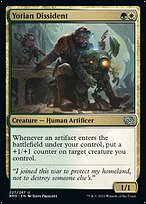

In [55]:
with Image.open(image_directory + "/{0}.jpg".format("Yotian Dissident")) as im:
  im.show()

## Show model picks with images

In [56]:
from PIL import Image, ImageDraw

def draw_red_outline_around_image(image):
  # Create a draw object
  draw = ImageDraw.Draw(image)

  # Get the width and height of the image
  width, height = image.size

  # Set the outline thickness
  thickness = 10

  # Draw a red outline around the image
  draw.rectangle((0, 0, width, height), outline=(255, 0, 0), width=thickness)


In [57]:
def plot_cards_by_name(names, per_image_scores=None):
  index_max = None
  if per_image_scores: 
    assert len(per_image_scores) == len(names)
    index_max = max(range(len(per_image_scores)), key=per_image_scores.__getitem__)

  num_images = len(names)
  # 5 images per row
  columns = 5
  rows = int((num_images - (num_images % 5)) / 5 + 1)
  
  # create figure
  fig = plt.figure(figsize=(columns*2, rows*2))

  for i, name in enumerate(names):
    image = Image.open(image_directory + "/{0}.jpg".format(name))
    if index_max is not None and index_max == i:
      draw_red_outline_around_image(image)
    array_im = np.asarray(image)
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(image)
    plt.axis('off')
    if per_image_scores:
      plt.title("{:1f}".format(per_image_scores[i]))
    
  plt.show()

def expand_card_counts(names_with_counts):
  names = []
  for name, count in names_with_counts:
    names.extend([name for i in range(int(count.item()))])
  return names

card_name_to_index = {c:i for i,c in enumerate(sorted_card_names)}
def get_scores_for_cards(names, predictions):
  return [predictions[card_name_to_index[n]].item() for n in names]

In [58]:
def print_test_example_with_images(index, inputs, predictions, actual_picked):
  # Pack.
  pack_names = card_vector_to_card_names(inputs[index][:_SET_SIZE_DIM])
  pack_names = expand_card_counts(pack_names)
  print("Pack with predicted scores:")
  plot_cards_by_name(pack_names, per_image_scores=get_scores_for_cards(pack_names, predictions[index]))
  # pool.
  pool_names = card_vector_to_card_names(inputs[index][_SET_SIZE_DIM:])
  print("Pool:")
  plot_cards_by_name(expand_card_counts(pool_names))
  # Sorted predictions
  print("Ranked predictions:\n", top_n_from_preds(index, predictions), "\n")
  # Highest predicted
  highest_predicted = torch.argmax(predictions, 1)
  print("highest pred:\n", sorted_card_names[highest_predicted[index].item()],"\n")
  # Human pick
  print("Human pick:\n", sorted_card_names[actual_picked[index].item()])
  


Pack with predicted scores:


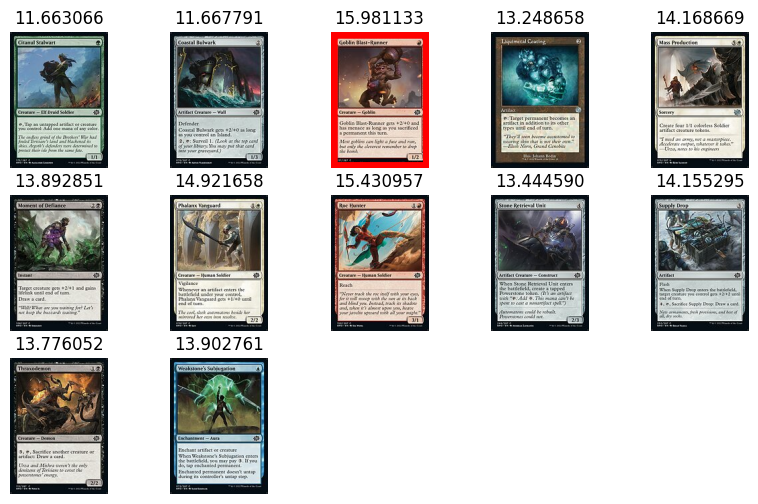

Pool:


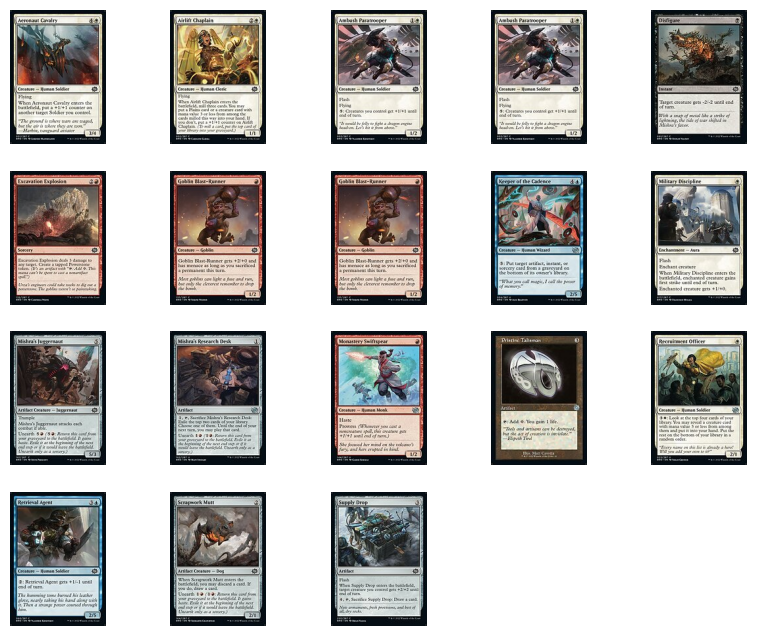

Ranked predictions:
 [('Goblin Blast-Runner', tensor(15.9811)), ('Roc Hunter', tensor(15.4310)), ('Phalanx Vanguard', tensor(14.9217)), ('Mass Production', tensor(14.1687)), ('Supply Drop', tensor(14.1553)), ("Weakstone's Subjugation", tensor(13.9028)), ('Moment of Defiance', tensor(13.8929)), ('Thraxodemon', tensor(13.7761)), ('Stone Retrieval Unit', tensor(13.4446)), ('Liquimetal Coating', tensor(13.2487)), ('Coastal Bulwark', tensor(11.6678)), ('Citanul Stalwart', tensor(11.6631))] 

highest pred:
 Goblin Blast-Runner 

Human pick:
 Phalanx Vanguard


In [59]:
print_test_example_with_images(88, inputs, y, actual_picked)

# Get arena ids from scryfall

In [67]:
def get_arena_id_mapping():
  mapping = {}
  for obj in get_all_the_bro_cards():
    name = obj["name"]
    try:
      arena_id = obj["arena_id"]
      mapping[arena_id] = name
    except:
      print("Couldn't get id for ", name)
  return mapping

In [70]:
name_arena_id_mapping = get_arena_id_mapping()

Couldn't get id for  Titania, Gaea Incarnate
Couldn't get id for  Mishra, Lost to Phyrexia
Couldn't get id for  Urza, Planeswalker


In [62]:
len(name_arena_id_mapping)

340

In [63]:
# these cards seem to not be available in boosters? ok
for name in name_arena_id_mapping.values():
  if name not in sorted_card_names:
    print(name)

Geology Enthusiast
Rescue Retriever
Artificer's Dragon
Terror Ballista
Woodcaller Automaton


In [64]:
_ARENA_ID_FILE = _PROJECT_BASE_DIR + "/data/BRO/per_card_data/arena_ids_to_names.json"

In [65]:
# json.dump(name_arena_id_mapping, open(_ARENA_ID_FILE, "w"))